In [1]:
import torch
import torchaudio

from pathlib import Path
from FileInfo import FileInfo

from matplotlib import pyplot as plt
from IPython.display import Audio, display

In [2]:
def choose_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [3]:
device = choose_device()
device

device(type='mps')

In [22]:
file_p: Path = list(Path("audio/").rglob("*mp3"))[0]
file_metadata = torchaudio.info(file_p.as_posix(), format='mp3')
str(file_metadata)

'AudioMetaData(sample_rate=44100, num_frames=8202159, num_channels=2, bits_per_sample=0, encoding=MP3)'

In [23]:
waveform, sample_rate = torchaudio.load(file_p.as_posix(), format='mp3')
# waveform = waveform[:,:100000]
waveform.shape, sample_rate

(torch.Size([2, 8202159]), 44100)

In [24]:
torchaudio.save("audio/test.wav", waveform, 16000)

In [29]:
file_p: Path = Path("audio/test.wav")
waveform, sample_rate = torchaudio.load(file_p.as_posix(), format='wav')
file_metadata = torchaudio.info(file_p.as_posix(), format='wav')
str(file_metadata)

'AudioMetaData(sample_rate=16000, num_frames=8202159, num_channels=2, bits_per_sample=16, encoding=PCM_S)'

In [6]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    if waveform.ndim == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    elif waveform.ndim == 1:
        display(Audio(waveform, rate=sample_rate))
    else:
        raise ValueError("Waveform must be 1 or 2 dimensional")

In [10]:
play_audio(waveform, sample_rate)

In [7]:
def _plot(waveform, sample_rate, title):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.linspace(0, num_frames / sample_rate, num_frames)
    
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        if title == "Waveform":
            axes[c].plot(time_axis, waveform[c], linewidth=1)
            axes[c].grid(True)
        else:
            axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform, sample_rate):
    _plot(waveform, sample_rate, "Waveform")
    
def plot_specgram(waveform, sample_rate):
    _plot(waveform, sample_rate, "Spectrogram")

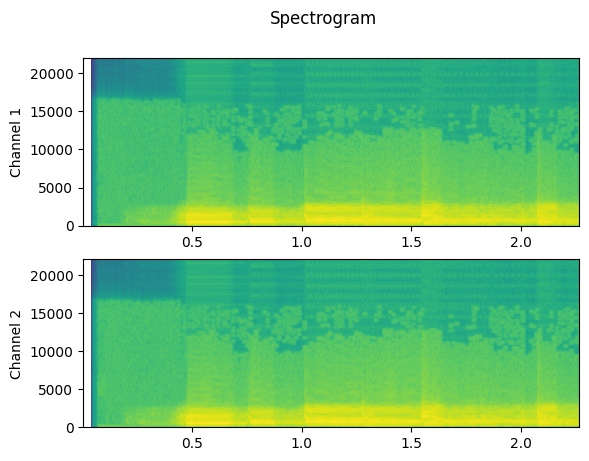

In [8]:
plot_specgram(waveform, sample_rate)

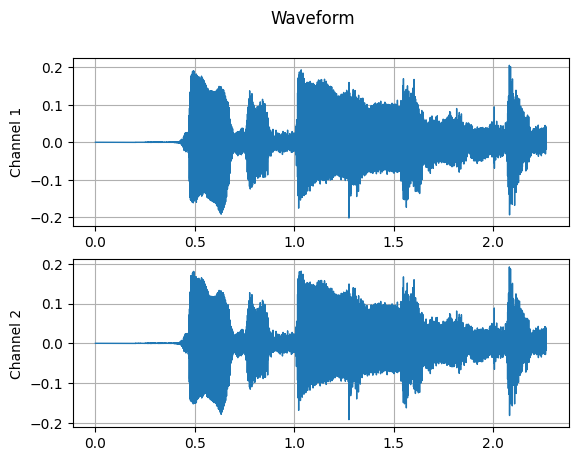

In [9]:
plot_waveform(waveform, sample_rate)

In [63]:
import torch
import zipfile
import torchaudio
from glob import glob

device = torch.device('cpu')  # gpu also works, but our models are fast enough for CPU
model, decoder, utils = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                       model='silero_stt',
                                       language='en', # also available 'de', 'es'
                                       device=device)
(read_batch, split_into_batches,
 read_audio, prepare_model_input) = utils  # see function signature for details

# download a single file in any format compatible with TorchAudio
test_files = list(Path.cwd().rglob("*.wav"))
batches = split_into_batches(test_files, batch_size=10)
input = prepare_model_input(read_batch(batches[0]), device=device)

output = model(input)
for example in output:
    print(decoder(example.cpu()))

Using cache found in /Users/minkota/.cache/torch/hub/snakers4_silero-models_master


In [3]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio]

zsh:1: no matches found: datasets[audio]


In [4]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline


torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
sample = "/Users/minkota/Documents/code/Projects/fromVideoToText/audio/test.wav"

result = pipe(sample)
print(result["text"])
